In [1]:
import gc
from pathlib import Path

import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import torch
import torch.nn as nn
import timm
import faiss
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import japanize_matplotlib
from sklearn.model_selection import StratifiedKFold, ParameterGrid
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
from torch.utils.data import DataLoader
from pytorch_metric_learning import losses

from models import (
    ArcFaceModelEfficientNetWithGem,
    get_scheduler,
    get_optimizer
)
from src.const import (
    TRAIN_CSV_WITH_IMG_PATH,
    QUERY_IMAGES_PATH,
    CITE_IMAGES_PATH,
    OUTPUT_ROOT,
    DATA_ROOT
)
from src.utils import (
    Logger,
    mrr_at_k_by_searched_index,
    seed_torch
)
from src.data_handler import (
    add_fold_idx,
    load_trainable_df,
    make_label_dict
)
from src.datasets import (
    TrainDataset,
    TestDataset
)
from src.searcher import SimilaritySearcher

In [3]:
class Config:
    name = 'train_arcface'
    out_dir = OUTPUT_ROOT / name / 'data_aug_select'
    out_dir.mkdir(parents=True, exist_ok=True)
    debug = False

    seed = 8823
    n_fold = 5
    trn_fold = [0, 1, 2, 3, 4]

    target_columns = ['meigara_label']
    img_size = 128
    embedding_dim = 512

    model_name = 'tf_efficientnet_b0.ns_jft_in1k'
    max_epochs = 5
    train_batch_size = 256
    valid_batch_size = 256
    num_workers = 4
    gradient_accumulation_steps = 1
    clip_grad_norm = 1000

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    optimizer = dict(
        optimizer_name="AdamW",
        lr=1e-4,
        weight_decay=1e-2,
        eps=1e-6,
        beta=(0.9, 0.999),
        encoder_lr=1e-4,
        decoder_lr=1e-4,
    )

    scheduler = dict(
        scheduler_name="cosine",
        num_warmup_steps_rate=0,
        num_cycles=0.5,
    )
    batch_scheduler = True

    margin = 17.2
    scale = 30


if Config.debug:
    Config.max_epochs = 2
    Config.n_fold = 2
    Config.trn_fold = [0, 1]
    Config.name = Config.name + "_debug"
    Config.img_size = 128
    Config.train_batch_size = 8

## データ拡張の追加

- ShiftScaleRotate(アフィン変換)
    - shift_limit => デフォルト
    - scale_limit => デフォルト
    - rotate_limit => +-20

- Cutout(ランダムにピクセルを黒塗り)
    - num_holes => 30
    - max_h_size => 10
    - max_w_size => 10

- oneof RandomBrightness, RandomContrast, RandomGamma

- ↑全部

In [4]:
def get_valid_transforms(img_size):
    return A.Compose([
        A.Resize(img_size, img_size),
        A.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225],
        ),
        ToTensorV2(),
    ])


def aug_shift_scale_rotate(img_size):
    return A.Compose([
        # 正方形切り出し
        A.RandomResizedCrop(img_size, img_size, scale=(0.85, 1.0)),
        A.ShiftScaleRotate(rotate_limit=20),
        A.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225],
        ),
        ToTensorV2(),
    ])


def aug_cutout(img_size):
    return A.Compose([
        # 正方形切り出し
        A.RandomResizedCrop(img_size, img_size, scale=(0.85, 1.0)),
        A.Cutout(num_holes=30, max_h_size=10, max_w_size=10),
        A.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225],
        ),
        ToTensorV2(),
    ])

def aug_color(img_size):
    return A.Compose([
        # 正方形切り出し
        A.RandomResizedCrop(img_size, img_size, scale=(0.85, 1.0)),
        A.OneOf([
            A.RandomBrightness(0.1),
            A.RandomContrast(0.1),
            A.RandomGamma()
        ], p=0.3),
        A.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225],
        ),
        ToTensorV2(),
    ])


def aug_shift_scale_rotate_and_cutout_and_color(img_size):
    return A.Compose([
        # 正方形切り出し
        A.RandomResizedCrop(img_size, img_size, scale=(0.85, 1.0)),
        A.OneOf([
            A.RandomBrightness(0.1),
            A.RandomContrast(0.1),
            A.RandomGamma()
        ], p=0.3),
        A.ShiftScaleRotate(rotate_limit=20),
        A.Cutout(num_holes=30, max_h_size=10, max_w_size=10),
        A.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225],
        ),
        ToTensorV2(),
    ])

In [5]:
# データの準備
(train_df, test_df, cite_df, sample_submission_df) = load_trainable_df(
    train_csv_path=DATA_ROOT / 'train.csv',
    test_csv_path=DATA_ROOT / 'test.csv',
    cite_csv_path=DATA_ROOT / 'cite.csv',
    sample_submission_csv_path=DATA_ROOT / 'sample_submission.csv',
    seed=Config.seed,
    debug=Config.debug
)
MLABEL2MEIGARA, BLABEL2BLAND = make_label_dict(train_df)
IDX2CITE_GID = cite_df.to_dict()["gid"]
train_df = add_fold_idx(
    train_df,
    Config.n_fold,
    seed=Config.seed,
    target_columns=Config.target_columns
)
train_df.head()

/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


,gid,filename,brand_id,meigara,brand_id_label,meigara_label,filepath,fold
0,200000001,200000001.jpg,3372,五橋,2211,445,/work/data/query_images/200000001.jpg,3
1,200000002,200000002.jpg,3751,庭のうぐいす,2454,1122,/work/data/query_images/200000002.jpg,4
2,200000003,200000003.jpg,2856,笑四季,1864,1819,/work/data/query_images/200000003.jpg,3
3,200000004,200000004.jpg,1527,鍋島,1005,2263,/work/data/query_images/200000004.jpg,1
4,200000005,200000005.jpg,2676,仙禽,1739,478,/work/data/query_images/200000005.jpg,2


### 拡張実験

#### aug_shift_scale_rotate

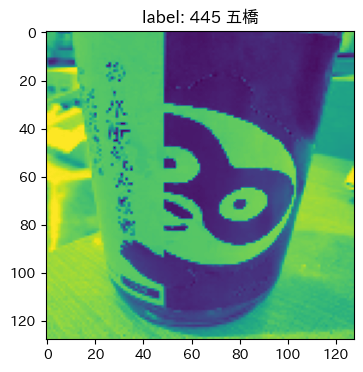

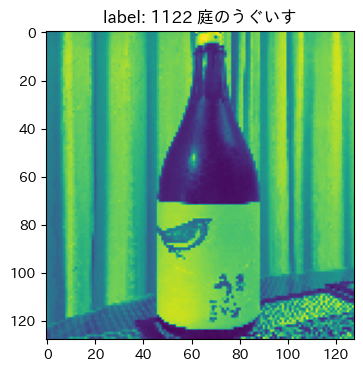

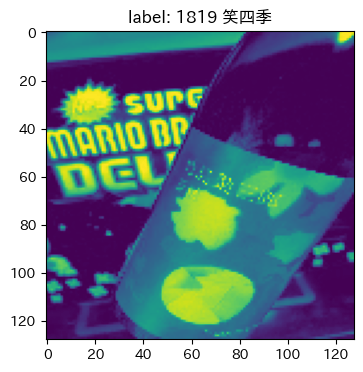

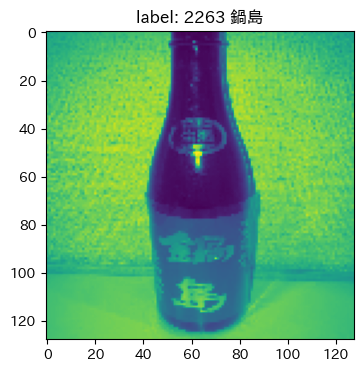

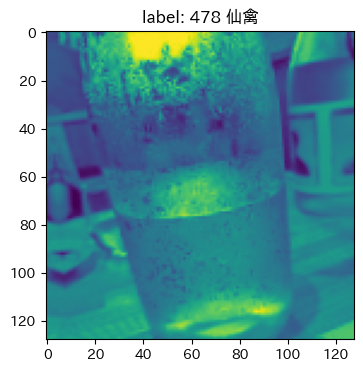

In [6]:
train_dataset = TrainDataset(
    df=train_df,
    transform_fn=aug_shift_scale_rotate(img_size=Config.img_size),
    target_columns=Config.target_columns
)
japanize_matplotlib.japanize()
for i in range(5):
    plt.figure(figsize=(4, 4))
    batch = train_dataset[i]
    image, label = batch["images"],  batch["targets"]
    plt.imshow(image[0])
    plt.title(f"label: {int(label)} {MLABEL2MEIGARA[int(label)]}")
    plt.show()

#### aug_cutout

/opt/conda/lib/python3.10/site-packages/albumentations/augmentations/dropout/cutout.py:49: FutureWarning: Cutout has been deprecated. Please use CoarseDropout
  warnings.warn(


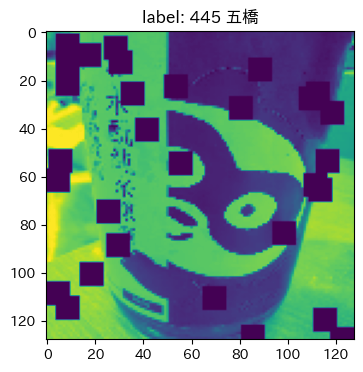

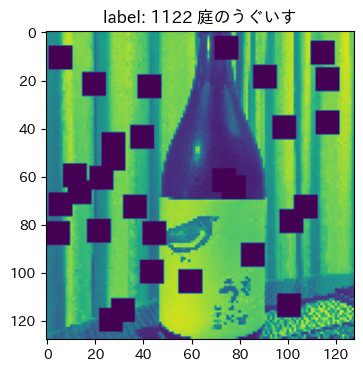

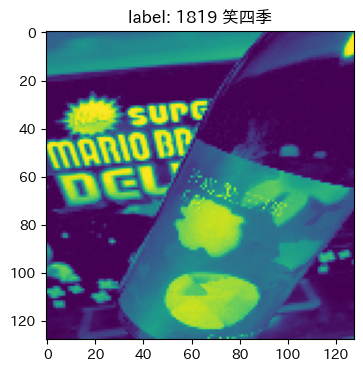

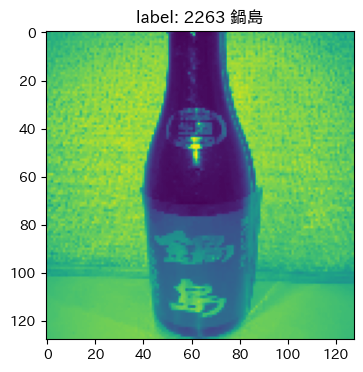

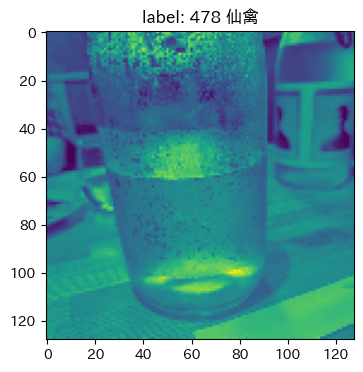

In [7]:
train_dataset = TrainDataset(
    df=train_df,
    transform_fn=aug_cutout(img_size=Config.img_size),
    target_columns=Config.target_columns
)
japanize_matplotlib.japanize()
for i in range(5):
    plt.figure(figsize=(4, 4))
    batch = train_dataset[i]
    image, label = batch["images"],  batch["targets"]
    plt.imshow(image[0])
    plt.title(f"label: {int(label)} {MLABEL2MEIGARA[int(label)]}")
    plt.show()

#### aug_color

/opt/conda/lib/python3.10/site-packages/albumentations/augmentations/transforms.py:1258: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/albumentations/augmentations/transforms.py:1284: FutureWarning: RandomContrast has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


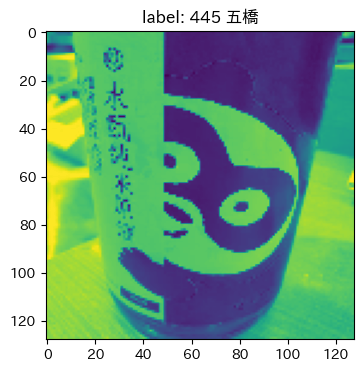

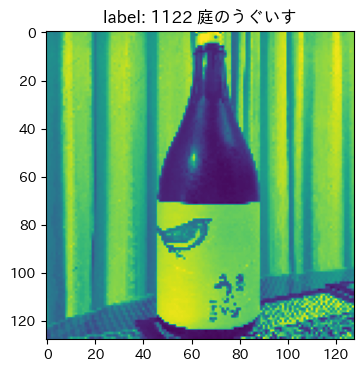

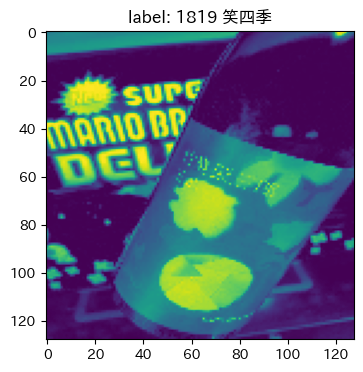

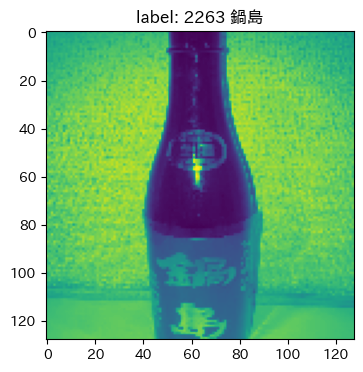

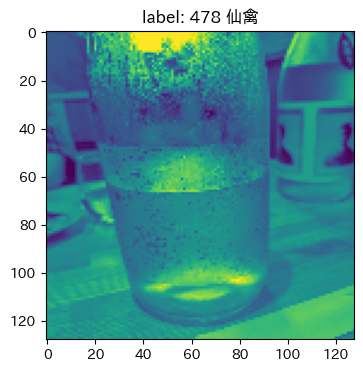

In [8]:
train_dataset = TrainDataset(
    df=train_df,
    transform_fn=aug_color(img_size=Config.img_size),
    target_columns=Config.target_columns
)
japanize_matplotlib.japanize()
for i in range(5):
    plt.figure(figsize=(4, 4))
    batch = train_dataset[i]
    image, label = batch["images"],  batch["targets"]
    plt.imshow(image[0])
    plt.title(f"label: {int(label)} {MLABEL2MEIGARA[int(label)]}")
    plt.show()

#### aug_shift_scale_rotate_and_cutout_and_color

/opt/conda/lib/python3.10/site-packages/albumentations/augmentations/transforms.py:1258: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/albumentations/augmentations/transforms.py:1284: FutureWarning: RandomContrast has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/albumentations/augmentations/dropout/cutout.py:49: FutureWarning: Cutout has been deprecated. Please use CoarseDropout
  warnings.warn(


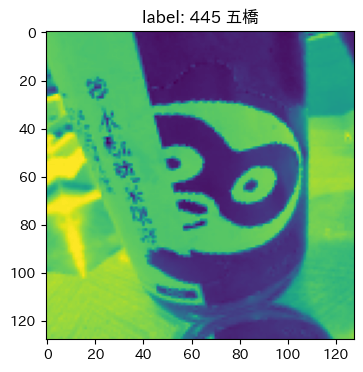

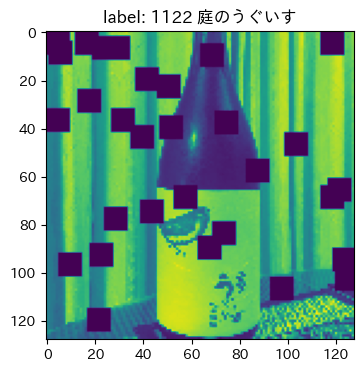

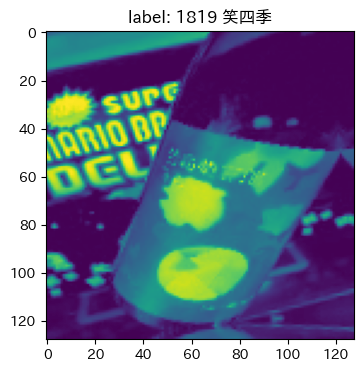

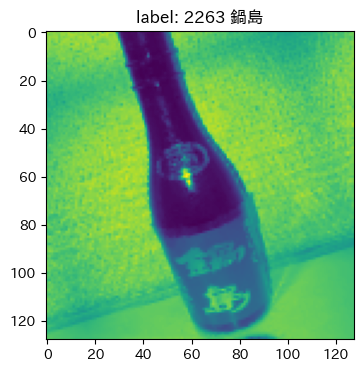

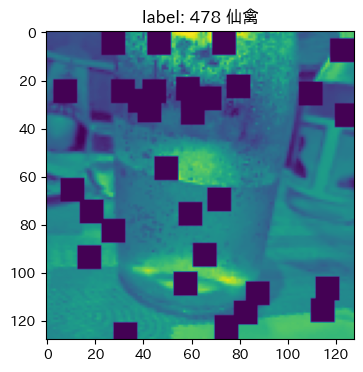

In [9]:
train_dataset = TrainDataset(
    df=train_df,
    transform_fn=aug_shift_scale_rotate_and_cutout_and_color(img_size=Config.img_size),
    target_columns=Config.target_columns
)
japanize_matplotlib.japanize()
for i in range(5):
    plt.figure(figsize=(4, 4))
    batch = train_dataset[i]
    image, label = batch["images"],  batch["targets"]
    plt.imshow(image[0])
    plt.title(f"label: {int(label)} {MLABEL2MEIGARA[int(label)]}")
    plt.show()

In [12]:
LOGGER = Logger(str(Config.out_dir))

In [13]:
def extract_features(model, data_loader, device):
    preds, targets = [], []
    model.eval()
    tbar = tqdm(data_loader, total=len(data_loader))
    for batch in tbar:
        for k, v in batch.items():
            batch[k] = v.to(device)
        with torch.no_grad():
            outputs = model(batch['images'])
        outputs = outputs.cpu().detach().numpy()
        target_labels = batch['targets'].cpu().detach().numpy()
        preds.append(outputs)
        targets.append(target_labels)
    return np.concatenate(preds), np.concatenate(targets)


def train_fn(
    config,
    model,
    dataloader,
    criterion,
    optimizer,
    scheduler,
    device,
    _custom_step,
):
    model.train()
    scaler = torch.cuda.amp.GradScaler()
    losses = []

    tbar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, batch in tbar:
        for k, v in batch.items():
            batch[k] = v.to(device)
        targets = batch["targets"]
        batch_size = targets.size(0)

        with torch.cuda.amp.autocast():
            batch_outputs = model(batch["images"], labels=batch["targets"])
            loss = criterion(batch_outputs, targets)

        if config.gradient_accumulation_steps > 1:
            loss = loss / config.gradient_accumulation_steps

        scaler.scale(loss).backward()
        if config.clip_grad_norm is not None:
            torch.nn.utils.clip_grad_norm_(model.parameters(), config.clip_grad_norm)
            torch.nn.utils.clip_grad_norm_(criterion.parameters(), config.clip_grad_norm)

        if (step + 1) % config.gradient_accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            _custom_step += 1

            if config.batch_scheduler:
                scheduler.step()

        losses.append(float(loss))
        tbar.set_description(f"loss: {np.mean(losses):.4f} lr: {scheduler.get_lr()[0]:.6f}")

    loss = np.mean(losses)
    return loss, _custom_step


def valid_fn(
    config,
    model,
    dataloader,
    criterion,
    device,
    _custom_step,
):
    model.eval()
    outputs, targets = [], []
    losses = []

    tbar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, batch in tbar:
        targets.append(batch["targets"])

        for k, v in batch.items():
            batch[k] = v.to(device)

        batch_size = batch["targets"].size(0)
        with torch.no_grad():
            batch_outputs = model(batch["images"], labels=batch["targets"])
            loss = criterion(batch_outputs, batch["targets"])

        if config.gradient_accumulation_steps > 1:
            loss = loss / config.gradient_accumulation_steps

        batch_outputs = torch.softmax(batch_outputs, dim=1)  # to proba
        batch_outputs = batch_outputs.to("cpu").numpy()
        outputs.append(batch_outputs)

        _custom_step += 1
        losses.append(float(loss))

        tbar.set_description(f"loss: {np.mean(losses):.4f}")

    outputs = np.concatenate(outputs)
    targets = np.concatenate(targets)

    loss = np.mean(losses)
    return (loss, outputs, targets, _custom_step)


def train_loop(
    config,
    train_df,
    valid_df,
    device,
    criterion,
    best_model_dst,
    train_trans,
    valid_trans
):
    LOGGER.info(f"========== training ==========")

    # dataset, dataloader
    train_dataset = TrainDataset(
        df=train_df,
        target_columns=config.target_columns,
        transform_fn=train_trans
    )
    train_dataset4feature = TrainDataset(
        df=train_df,
        target_columns=config.target_columns,
        transform_fn=valid_trans
    )
    valid_dataset = TrainDataset(
        df=valid_df,
        target_columns=config.target_columns,
        transform_fn=valid_trans
    )
    train_dataloader = DataLoader(
        train_dataset,
        batch_size=config.train_batch_size,
        shuffle=True,
        num_workers=config.num_workers,
        pin_memory=True,
        drop_last=True,
    )
    train_dataloader4feature = DataLoader(
        train_dataset4feature,
        batch_size=config.valid_batch_size,
        num_workers=config.num_workers,
        pin_memory=True,
        drop_last=False,
    )
    valid_dataloader = DataLoader(
        valid_dataset,
        batch_size=config.valid_batch_size,
        shuffle=False,
        num_workers=config.num_workers,
        pin_memory=True,
        drop_last=False,
    )

    # set model & optimizer
    model = ArcFaceModelEfficientNetWithGem(config, out_dim=config.embedding_dim, pretrained=True)
    model.to(device)
    criterion.to(device)
    params = [
        {'params': model.parameters()},
        {'params': criterion.parameters()}
    ]
    optimizer = get_optimizer(optimizer_config=config.optimizer, params=params)

    # set scheduler
    num_train_steps = int(
        len(train_dataloader) * config.max_epochs // config.gradient_accumulation_steps
    )
    scheduler = get_scheduler(
        scheduler_config=config.scheduler, optimizer=optimizer, num_train_steps=num_train_steps
    )

    # loop
    best_loss = np.inf
    tr_step, val_step = 0, 0
    for epoch in range(Config.max_epochs):
        # training
        loss, tr_step = train_fn(
            config=config,
            model=model,
            dataloader=train_dataloader,
            criterion=criterion,
            optimizer=optimizer,
            scheduler=scheduler,
            device=device,
            _custom_step=tr_step,
        )

        # validation
        val_loss, val_outputs, val_targets, val_step = valid_fn(
            config=config,
            model=model,
            dataloader=valid_dataloader,
            criterion=criterion,
            device=device,
            _custom_step=val_step,
        )

        logs = {
            "Epoch": epoch,
            "train_loss_epoch": loss.item(),
            "valid_loss_epoch": val_loss.item(),
        }
        LOGGER.info(logs)

        if best_loss > val_loss.item():
            best_loss = val_loss.item()
            LOGGER.info(f"epoch {epoch} - best loss: {best_loss:.4f} model")

            torch.save(
                model.state_dict(),
                best_model_dst
            )

        if not config.batch_scheduler:
            scheduler.step()

    torch.cuda.empty_cache()
    gc.collect()
    model = ArcFaceModelEfficientNetWithGem(config, out_dim=config.embedding_dim, pretrained=True)
    model.load_state_dict(torch.load(best_model_dst))
    model.to(device)
    train_preds, train_targets = extract_features(model, train_dataloader4feature, config.device)
    valid_preds, valid_targets = extract_features(model, valid_dataloader, config.device)
    searcher = SimilaritySearcher(train_preds)
    _, I = searcher.search(valid_preds)
    mrr = mrr_at_k_by_searched_index(valid_targets, train_targets, I)
    return mrr

In [14]:
seed_torch()

augs = {
    'aug_shift_scale_rotate': aug_shift_scale_rotate(Config.img_size),
    'aug_cutout': aug_cutout(Config.img_size),
    'aug_color': aug_color(Config.img_size),
    'aug_shift_scale_rotate_and_cutout_and_color': aug_shift_scale_rotate_and_cutout_and_color(Config.img_size)
}

results = []
for aug_name, aug in augs.items():
    LOGGER.info(aug_name)
    fold_mrr = []
    for i_fold in range(Config.n_fold):
        if i_fold not in Config.trn_fold:
            continue
        LOGGER.info(f'fold-{i_fold} start')
        best_model_dst = Config.out_dir / aug_name / f'fold_{i_fold}.pth'
        best_model_dst.parent.mkdir(parents=True, exist_ok=True)
        train_df_fold = train_df[train_df["fold"] != i_fold]
        valid_df_fold = train_df[train_df["fold"] == i_fold]
        criterion = losses.ArcFaceLoss(
            num_classes=len(BLABEL2BLAND),
            embedding_size=Config.embedding_dim,
            margin=Config.margin,
            scale=Config.scale
        )
        mrr = train_loop(
            Config,
            train_df_fold,
            valid_df_fold,
            Config.device,
            criterion,
            best_model_dst,
            train_trans=aug,
            valid_trans=get_valid_transforms(Config.img_size)
        )
        fold_mrr.append(mrr)
    LOGGER.info(f'mean of mrr: {np.mean(fold_mrr)}')
    results.append(
        {
            'aug_name': aug_name,
            'mrr': np.mean(fold_mrr),
        }
    )
results = pd.DataFrame(results)

[2023-07-15 15:22:34] - aug_shift_scale_rotate
[2023-07-15 15:22:34] - fold-0 start
[2023-07-15 15:22:34] - ========== training ==========
  0% 0/338 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:265: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
loss: 15.1858 lr: 0.000090: 100% 338/338 [02:11<00:00,  2.58it/s]
loss: 13.5484: 100% 85/85 [00:32<00:00,  2.59it/s]
[2023-07-15 15:25:19] - {'Epoch': 0, 'train_loss_epoch': 15.185807473560763, 'valid_loss_epoch': 13.548356953789206}
[2023-07-15 15:25:19] - epoch 0 - best loss: 13.5484 model
loss: 12.2110 lr: 0.000065: 100% 338/338 [02:11<00:00,  2.58it/s]
loss: 11.1545: 100% 85/85 [00:31<00:00,  2.66it/s]
[2023-07-15 15:28:03] - {'Epoch': 1, 'train_loss_epoch': 12.210992164160373, 'valid_loss_epoch': 11.154526104646571}
[2023-07-15 15:28:03] - epoch 1 - best loss: 11.1545 model
l

In [15]:
display(results.sort_values(by='mrr', ascending=False))
results.to_csv(Config.out_dir / 'mrr_logs.csv', index=False)

,aug_name,mrr
0,aug_shift_scale_rotate,0.696173
2,aug_color,0.695010
1,aug_cutout,0.671038
3,aug_shift_scale_rotate_and_cutout_and_color,0.668437
